In [2]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os

# These are all of the libraries that I manually created
import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process

#
# Through Thorlabs
#
# start_index = 32  # Start index 32 is the full spectrum (from 195nm)
# start_index = 774 # starts at 350nm
#
# Through 3D slicer
#
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm



### Data Loading and Formatting 
#### Load in (IO)
* Load in the raw data + baselines and convert it into a useable list of numpy arrays
* Broadband output
* White paper

In [3]:
# This function combines loading the data with 
def loadDataset(dataPath,start_index=790,end_index=-1,sep=','):
    Dataset = []
    print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
        # for each file in the director, make each line a row in a numpy array
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        # Trim to 360 nm
        df = df.iloc[:, start_index:]
        # convert to an array
        data_arr = df.to_numpy()
        # Grab the wavelength values
        wavelength_arr = data_arr[0, 1:]
        # for each row in the csv, extract the spectrum
        for i in range(1,data_arr.shape[0]):
            spectrum_arr = data_arr[i,1:]
            # Concatenate the vectors as columns
            data_single = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
            Dataset.append(data_single)
    # Convert to numpy array
    Dataset = np.array(Dataset,dtype='float')
    return Dataset,wavelength_arr

# LOADING DATASET 
FORMAT_DATASET = True
dataset_name = 'OpticalCavityRecon'
trialPath = "C:/Spectroscopy_TrackedTissueSensing/CavReconDemo/data/Apr16/PatientA"
class0_name = 'Normal'
class1_name = 'Cancer'
dataPath0 = os.path.join(trialPath,class0_name)
dataPath1 = os.path.join(trialPath,class1_name)

# Load in the data
data_0, wavelength = loadDataset(dataPath0,start_index=start_index, sep=',')
labels_0 = 0*np.ones(len(data_0))
data_1, wavelength = loadDataset(dataPath1,start_index=start_index, sep=',')
labels_1 = 1*np.ones(len(data_1))

print("data_0.shape: ", data_0.shape)
print("data_1.shape: ", data_1.shape)

Loading in:  C:/Spectroscopy_TrackedTissueSensing/CavReconDemo/data/Apr16/PatientA\Normal
Loading in:  C:/Spectroscopy_TrackedTissueSensing/CavReconDemo/data/Apr16/PatientA\Cancer
data_0.shape:  (322, 2858, 2)
data_1.shape:  (121, 2858, 2)


In [4]:
print(data_0[0,:,0])

[ 360.14014913  360.35511553  360.57009705 ... 1022.77496128 1023.01976654
 1023.26457759]


In [5]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

# # LOAD IN BASELINES


dataPath_BrOut = "C:/Spectroscopy_TrackedTissueSensing/CavReconDemo/SLS201L_Spectrum_reformatted.csv"
print(dataPath_BrOut)
baseline_BrOut_raw = loadSpectrum(dataPath_BrOut, 'Wavelength', start_index=10, end_index=675, sep=',')
# Interpolate such that the downloaded spectrum has the same values of the data
x = baseline_BrOut_raw[:,0]
y = baseline_BrOut_raw[:,1]
f = interpolate.interp1d(x,y)
xnew = wavelength
ynew = f(xnew)
baseline_BrOut = np.transpose(np.array([xnew,ynew]))
print(baseline_BrOut.shape)
print('Data shape', data_0.shape)
print(np.min(baseline_BrOut))

C:/Spectroscopy_TrackedTissueSensing/NassirDemo/SLS201L_Spectrum_reformatted.csv


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Spectroscopy_TrackedTissueSensing/NassirDemo/SLS201L_Spectrum_reformatted.csv'

360.14014912872346


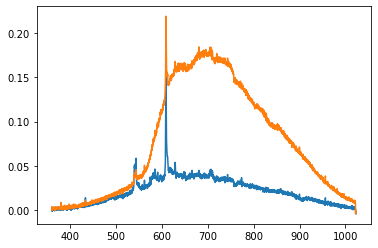

In [ ]:
plt.plot(data_0[0,:,0],data_0[0,:,1])
plt.plot(data_1[0,:,0],data_1[0,:,1])
data_0.shape
print(data_0[0,0,0])

### Display the raw data
* Display a pork and chicken sample
* Display the broadband source output

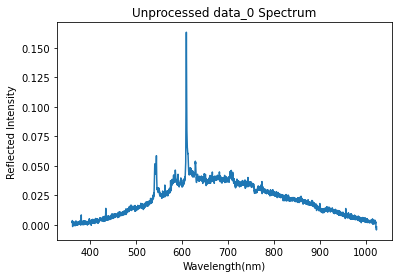

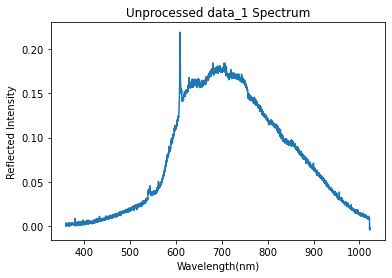

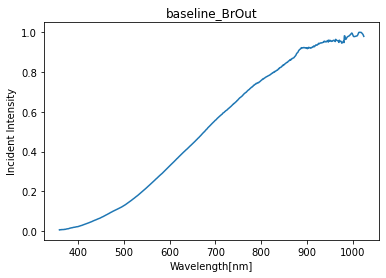

In [ ]:
# Displaying all of the spectra to visually inspect results

# GUI.plotall(data_0)
# GUI.plotall(data_1)

# This should be in GUI with all the inputs as parameters
wavelength_start = data_0[0,0,0]
wavelength_end = data_0[0,-1,0]

w = np.linspace(wavelength_start,wavelength_end,len(data_0[1]))
# Display an example of data_0
GUI.plotSpectra(xdata=data_0[0,:,0],ydata=data_0[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_0 Spectrum')
# Display an example of data_1
GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_1 Spectrum' )
# # Display an example of paper
# GUI.plotSpectra(xdata=baseline_pap[:,1],ydata=baseline_pap[:,0],xlab="Wavelength[nm]",
#             ylab='Reflected Intensity',title='baseline_pap')
# Display an example of broadband output
GUI.plotSpectra(xdata=baseline_BrOut[:,0],ydata=baseline_BrOut[:,1],xlab="Wavelength[nm]",
            ylab='Incident Intensity',title='baseline_BrOut')

In [ ]:
# Find a list of the max values in the training set
max_values = []
for i in range(len(data_1[:,0,0])):
    max_values.append(np.max(data_1[i,:,1]))
# Remove all spectra with a max value less then 0.1 and more than 0.99
# plt.plot(max_values)
# print(max_values)
# plt.figure()
# plt.plot(np.transpose(data_0[:,:,1]))

### Preprocessing of the data
* Crop to 360nm to 1024nm
* Normalize (MinMax norm)
* Subtract the normalized broadband output
* Dimensionality reduction
* Max binning?

(146, 2578, 2)
(2578,)


Text(0.5, 1.0, 'Signal with broadband transfer function removed')

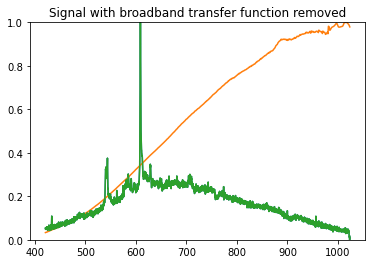

In [ ]:
FLAG_Baseline = False
# Load in the baseline 
baseline = baseline_BrOut # --------------------------------- flag
# baseline = baseline_pap[:,:]
baseline = process.normalize(baseline)[:,1]

data_norm = data_0[:,280:,:].copy()
baseline = baseline[280:].copy()

# Normalize the peak of the signal to 1. This allows us to find the proportional height above the baseline
data_norm = process.normalize(data_norm)
# Arguments
inputData = data_norm
tFunc = baseline
print(inputData.shape)
print(tFunc.shape)

flag = FLAG_Baseline
def divTfuc(inputData,tFunc, flag):    
    outputData = inputData.copy()
    if FLAG_Baseline:
        # For each spectra
        for i in range (inputData[:,:,1].shape[0]):
            data = inputData[i,:,1]
            # Divide by the baseline transfer function
            outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData
# call the function
outputData = divTfuc(inputData,tFunc, flag)
# Display the arguemtns and output
freq = data_norm[0,:,0]
plt.figure()
plt.plot(freq,inputData[0,:,1]) 
plt.plot(freq,tFunc)
plt.plot(freq,outputData[0,:,1])
plt.ylim([0,1])
plt.title('Signal with broadband transfer function removed')

In [ ]:
# Normalize all data
# cropStart = 280 # 420nm
cropStart = 0 # 360nm
data_0_norm = divTfuc(data_0[:,cropStart:,:], baseline,FLAG_Baseline)
data_0_saved = data_0_norm.copy()
print('shape:', data_0_norm.shape)
# data_0_norm = process.subtractBaseline(data_0_norm,baseline)
# data_0_norm = process.normalize(data_0_norm)

data_1_norm = divTfuc(data_1[:,cropStart:,:], baseline,FLAG_Baseline)
data_1_saved = data_1_norm.copy()

print('Size of data_0,', data_0_norm.shape)
print('Size of data_1,', data_1_norm.shape)
print(tFunc.min())


shape: (146, 2858, 2)
Size of data_0, (146, 2858, 2)
Size of data_1, (124, 2858, 2)
0.03321808470462091


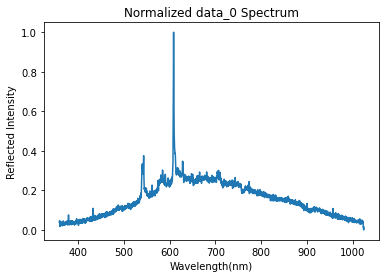

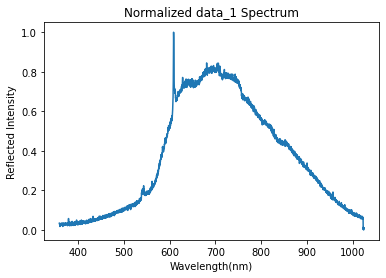

In [ ]:
# Plots of the normalized spectra
GUI.plotSpectra(xdata=data_0_norm[0,:,0],ydata=data_0_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_0 Spectrum' )
GUI.plotSpectra(xdata=data_1_norm[0,:,0],ydata=data_1_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_1 Spectrum' )

# Training and Testing

### Stratify data

In [ ]:
# plt.plot(np.transpose(data_0_norm[:,:,1]))
# plt.plot(np.transpose(data_1_norm[:,:,1]))

print(data_0_norm.shape)
print(labels_0.shape)
print(data_1_norm.shape)
print(labels_1.shape)


(146, 2858, 2)
(146,)
(124, 2858, 2)
(124,)


### Train ML models

In [ ]:
# This is revamped to just train the classifier and save it
import sklearn
print("sklearn version: ",sklearn.__version__)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score,roc_auc_score

inferenceFlag = True 
# if the model is being trained for inference in 3D slicer, use all the data
if inferenceFlag is True:
    X_train = np.concatenate([data_0_norm[:,:,1],data_1_norm[:,:,1]])
    y_train = np.concatenate([labels_0,labels_1])

    # Instantiate the model
    modelKNN = KNeighborsClassifier(n_neighbors=3)

    # Train the model
    modelKNN.fit(X_train,y_train)

    # Save the model to file
    from joblib import dump, load
    dump(modelKNN, 'Models/'+dataset_name+ '.joblib') 

sklearn version:  1.1.1
